This notebook follows this article:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/twitter-issue-classification/products-issue-classification/train.csv
/kaggle/input/twitter-issue-classification/products-issue-classification/test.csv


In [2]:
df = pd.read_csv('../input/twitter-issue-classification/products-issue-classification/train.csv', nrows=99999, engine='python') # limiting the rows
df.head()

,description,categories
0,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,This twoway light features a bright flashlight...,Health & Personal Care


In [3]:
df = df[pd.notnull(df['description'])]

In [4]:
df = df[pd.notnull(df['categories'])]

In [5]:
df.head()

,description,categories
0,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,This twoway light features a bright flashlight...,Health & Personal Care


For this project, we need only two columns — “Product” and “Consumer complaint narrative”.

Input: Consumer_complaint_narrative
Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”

Output: product
Example: Credit reporting

We will remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.
We also create a couple of dictionaries for future use.

In [6]:
col = ['categories', 'description']
df = df[col]

In [7]:
df.head()

,categories,description
0,"Arts, Crafts & Sewing",Solder Pick for picking up molten solder when ...
1,Cell Phones & Accessories,We all screen. And we all need to protect thos...
2,"Clothing, Shoes & Jewelry","Bringing you precision at a glance, the Casio ..."
3,Tools & Home Improvement,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...
4,Health & Personal Care,This twoway light features a bright flashlight...


In [8]:
from io import StringIO
col = ['categories', 'description']
df = df[col]
df = df[pd.notnull(df['description'])]
df.columns = ['categories', 'description']
df['Number'] = df['categories'].factorize()[0]
Number_df = df[['categories', 'Number']].drop_duplicates().sort_values('Number')
Number_to_id = dict(Number_df.values)
id_to_Number = dict(Number_df[['Number', 'categories']].values)
df.head()

,categories,description,Number
0,"Arts, Crafts & Sewing",Solder Pick for picking up molten solder when ...,0
1,Cell Phones & Accessories,We all screen. And we all need to protect thos...,1
2,"Clothing, Shoes & Jewelry","Bringing you precision at a glance, the Casio ...",2
3,Tools & Home Improvement,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,3
4,Health & Personal Care,This twoway light features a bright flashlight...,4


In [9]:
Number_to_id

{'Arts, Crafts & Sewing': 0,
 'Cell Phones & Accessories': 1,
 'Clothing, Shoes & Jewelry': 2,
 'Tools & Home Improvement': 3,
 'Health & Personal Care': 4,
 'Baby Products': 5,
 'Baby': 6,
 'Patio, Lawn & Garden': 7,
 'Beauty': 8,
 'Sports & Outdoors': 9,
 'Electronics': 10,
 'All Electronics': 11,
 'Automotive': 12,
 'Toys & Games': 13,
 'All Beauty': 14,
 'Office Products': 15,
 'Appliances': 16,
 'Musical Instruments': 17,
 'Industrial & Scientific': 18,
 'Grocery & Gourmet Food': 19,
 'Pet Supplies': 20,
 'sync': 21,
 'sleep': 22,
 'battery': 23,
 'display': 24}

In [10]:
df.head()

,categories,description,Number
0,"Arts, Crafts & Sewing",Solder Pick for picking up molten solder when ...,0
1,Cell Phones & Accessories,We all screen. And we all need to protect thos...,1
2,"Clothing, Shoes & Jewelry","Bringing you precision at a glance, the Casio ...",2
3,Tools & Home Improvement,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,3
4,Health & Personal Care,This twoway light features a bright flashlight...,4


<Figure size 576x432 with 0 Axes>

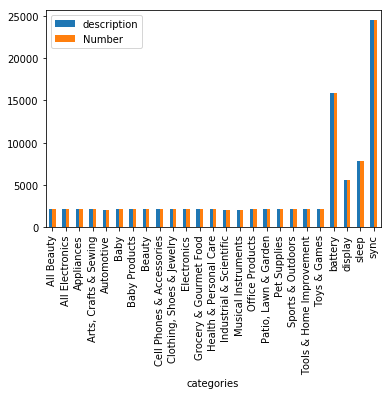

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('categories').count().plot.bar(ylim=0)
plt.show()

The data looks imbalanced. 

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. 

For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

We will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. 

We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
1. sublinear_df is set to True to use a logarithmic form for frequency.
1. min_df is the minimum numbers of documents a word must be present in to be kept.
1. norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
1. ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
1. stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=50, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(df['description']).toarray()
labels = df.Number
features.shape

(98953, 8578)

In [13]:
# We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for categories, Number in sorted (Number_to_id.items()):
    features_chi2 = chi2(features, labels == Number)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(categories))
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'All Beauty':
 Most correlated unigrams:
. hair
. skin
 Most correlated bigrams:
. fine lines
. careproduct size
# 'All Electronics':
 Most correlated unigrams:
. dvd
. tv
 Most correlated bigrams:
. hard drive
. shield protector
# 'Appliances':
 Most correlated unigrams:
. frigidaire
. whirlpool
 Most correlated bigrams:
. whirlpool number
. genuine replacement
# 'Arts, Crafts & Sewing':
 Most correlated unigrams:
. needle
. sewing
 Most correlated bigrams:
. conforms astm
. sewing machine
# 'Automotive':
 Most correlated unigrams:
. wiring
. vehicle
 Most correlated bigrams:
. special metalized
. polyester film
# 'Baby':
 Most correlated unigrams:
. stroller
. baby
 Most correlated bigrams:
. car seats
. car seat
# 'Baby Products':
 Most correlated unigrams:
. bank
. baby
 Most correlated bigrams:
. diaper rash
. baby skin
# 'Beauty':
 Most correlated unigrams:
. hair
. skin
 Most correlated bigrams:
. design house
. oil free
# 'Cell Phones & Accessories':
 Most correlated unigrams

## Multi-Class Classifier

In [14]:
X_train = features
Y_train = labels

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

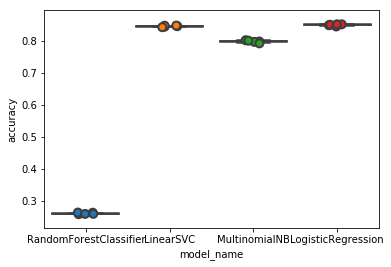

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.846634
LogisticRegression        0.850505
MultinomialNB             0.798894
RandomForestClassifier    0.261053
Name: accuracy, dtype: float64

In [17]:
# Continue with our best model (LogisticRegression), we are going to look at the confusion matrix, 
# and show the discrepancies between predicted and actual labels.
from sklearn.model_selection import train_test_split
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [24]:
datas = pd.read_csv('../input/fitbit-tweets-dataset/FITBIT_TWEETS.csv', nrows=99999, engine='python') # limiting the rows

In [25]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

In [31]:
my_submission = pd.DataFrame({'id': datas.id, 'date': datas.date, 'tweet': datas.tweet, 'category':datas.category})
# you could use any filename. We choose submission here

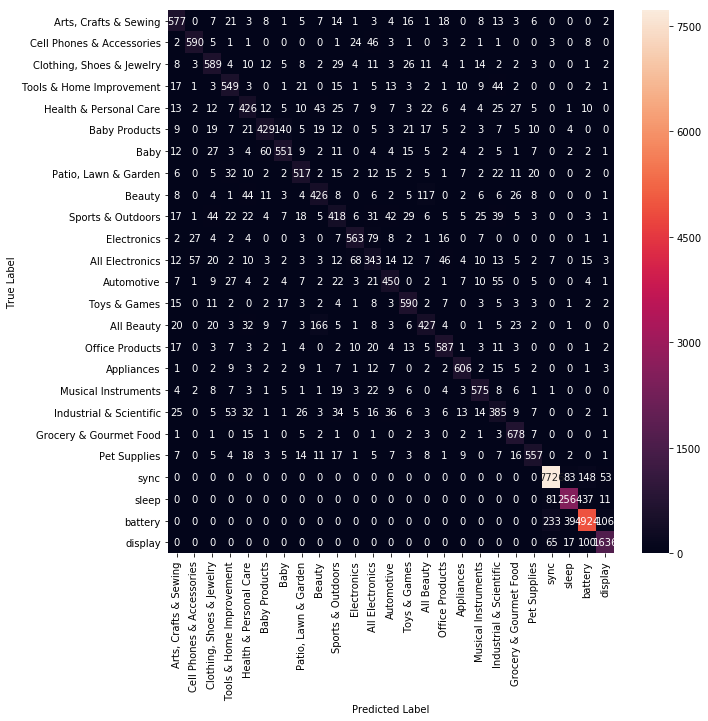

In [32]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=Number_df.categories.values, yticklabels=Number_df.categories.values)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [33]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['categories'].unique()))

                           precision    recall  f1-score   support

    Arts, Crafts & Sewing       0.74      0.80      0.77       718
Cell Phones & Accessories       0.86      0.85      0.86       692
Clothing, Shoes & Jewelry       0.73      0.78      0.76       754
 Tools & Home Improvement       0.72      0.78      0.75       703
   Health & Personal Care       0.64      0.62      0.63       685
            Baby Products       0.76      0.58      0.66       743
                     Baby       0.73      0.75      0.74       733
     Patio, Lawn & Garden       0.77      0.75      0.76       692
                   Beauty       0.61      0.62      0.62       688
        Sports & Outdoors       0.62      0.55      0.58       758
              Electronics       0.80      0.77      0.79       727
          All Electronics       0.51      0.51      0.51       673
               Automotive       0.71      0.70      0.70       644
             Toys & Games       0.78      0.86      0.82     

In [34]:
# Some manual tests for new input data
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request",
        "I had severe battery problems with my phone", "My phone switched off early", "The PC was not getting in sleep mode", "How can I see sleep info in my mobile?"]
text_features = tfidfVector.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - category: '{}'".format(id_to_Number[predicted]))
    print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - category: 'Baby Products'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - category: 'Sports & Outdoors'

"I can't get the money out of the country."
  - category: 'Baby Products'

"I have no money to pay my tuition"
  - category: 'Baby Products'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - category: 'sync'

"I had severe battery problems with my phone"
  - category: 'battery'

"My phone switched off early"
  - category: 'Cell Phones & Accessories'

"The PC was not getting in sleep mode"
  - category: 'sleep'

"How can I see sleep info in my mobile?"
  - category: 'sleep'



In [35]:
my_submission.to_csv('finalized_dataset.csv', index=False)

In [38]:
dataset = pd.read_csv('../input/twitter-issue-classification/products-issue-classification/test.csv', usecols=["description"], nrows=99999, engine='python')
dataset.head()
dataset = dataset[pd.notnull(dataset['description'])]
dataset.head()

,description
0,Solder Pick for picking up molten solder when ...
1,We all screen. And we all need to protect thos...
2,"Bringing you precision at a glance, the Casio ..."
3,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...
4,This twoway light features a bright flashlight...


In [39]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [41]:
replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
bad_symbols_re = re.compile('[^0-9a-z #+_]')
links_re = re.compile('(www|http)\S+')

In [42]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

(-0.5, 399.5, 199.5, -0.5)

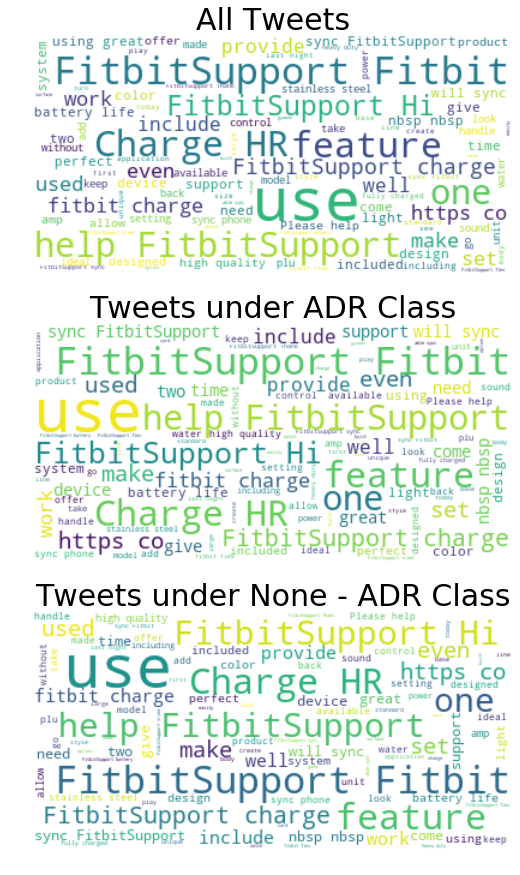

In [43]:
description_All = " ".join(review for review in dataset.description)
description_ADR = " ".join(review for review in dataset.description)
description_NADR = " ".join(review for review in dataset.description)
fig, ax = plt.subplots(3, 1, figsize  = (15,15))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(description_All)
wordcloud_ADR = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(description_ADR)
wordcloud_NADR = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(description_NADR)

ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_ADR, interpolation='bilinear')
ax[1].set_title('Tweets under ADR Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_NADR, interpolation='bilinear')
ax[2].set_title('Tweets under None - ADR Class',fontsize=30)
ax[2].axis('off')

In [46]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

dataset['description_punct'] = dataset['description'].apply(lambda x: remove_punct(x))
dataset.head(10)

,description,description_punct
0,Solder Pick for picking up molten solder when making jewelry,Solder Pick for picking up molten solder when making jewelry
1,We all screen. And we all need to protect those screens on our expensive little gadgetry. Our ea...,We all screen And we all need to protect those screens on our expensive little gadgetry Our each...
2,"Bringing you precision at a glance, the Casio Men's Databank Digital Watch #DBC310-1 features a ...",Bringing you precision at a glance the Casio Mens Databank Digital Watch DBC features a bluetone...
3,Factory-Reconditioned DEWALT DW260KR Heavy-Duty 6.2 Amp Screwdriver Kit,FactoryReconditioned DEWALT DWKR HeavyDuty Amp Screwdriver Kit
4,"This twoway light features a bright flashlight beam and adjustable, heavyduty rubber casing side...",This twoway light features a bright flashlight beam and adjustable heavyduty rubber casing sides...
5,This adorable ducky makes the perfect gift for children. Large enough to hold lots of coins and ...,This adorable ducky makes the perfect gift for children Large enough to hold lots of coins and y...
6,Lilypadz are the revolutionary alternative to traditional nursing pads combining such unique fea...,Lilypadz are the revolutionary alternative to traditional nursing pads combining such unique fea...
7,Light weight double stroller that is perfect for travel,Light weight double stroller that is perfect for travel
8,Eastman Outdoors offers High-Quality cooking products that outdoor chefs are hungering for. Pro...,Eastman Outdoors offers HighQuality cooking products that outdoor chefs are hungering for Produ...
9,"This toddler bed is for your little king or queen. Since it easily converts to a full bed, you c...",This toddler bed is for your little king or queen Since it easily converts to a full bed you can...


In [48]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

dataset['description_tokenized'] = dataset['description_punct'].apply(lambda x: tokenization(x.lower()))
dataset.head()

,description,description_punct,description_tokenized
0,Solder Pick for picking up molten solder when making jewelry,Solder Pick for picking up molten solder when making jewelry,"[solder, pick, for, picking, up, molten, solder, when, making, jewelry]"
1,We all screen. And we all need to protect those screens on our expensive little gadgetry. Our ea...,We all screen And we all need to protect those screens on our expensive little gadgetry Our each...,"[we, all, screen, and, we, all, need, to, protect, those, screens, on, our, expensive, little, g..."
2,"Bringing you precision at a glance, the Casio Men's Databank Digital Watch #DBC310-1 features a ...",Bringing you precision at a glance the Casio Mens Databank Digital Watch DBC features a bluetone...,"[bringing, you, precision, at, a, glance, the, casio, mens, databank, digital, watch, dbc, featu..."
3,Factory-Reconditioned DEWALT DW260KR Heavy-Duty 6.2 Amp Screwdriver Kit,FactoryReconditioned DEWALT DWKR HeavyDuty Amp Screwdriver Kit,"[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]"
4,"This twoway light features a bright flashlight beam and adjustable, heavyduty rubber casing side...",This twoway light features a bright flashlight beam and adjustable heavyduty rubber casing sides...,"[this, twoway, light, features, a, bright, flashlight, beam, and, adjustable, heavyduty, rubber,..."


In [49]:
stopword = nltk.corpus.stopwords.words('english')

In [50]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
dataset['description_nonstop'] = dataset['description_tokenized'].apply(lambda x: remove_stopwords(x))
dataset.head(10)

,description,description_punct,description_tokenized,description_nonstop
0,Solder Pick for picking up molten solder when making jewelry,Solder Pick for picking up molten solder when making jewelry,"[solder, pick, for, picking, up, molten, solder, when, making, jewelry]","[solder, pick, picking, molten, solder, making, jewelry]"
1,We all screen. And we all need to protect those screens on our expensive little gadgetry. Our ea...,We all screen And we all need to protect those screens on our expensive little gadgetry Our each...,"[we, all, screen, and, we, all, need, to, protect, those, screens, on, our, expensive, little, g...","[screen, need, protect, screens, expensive, little, gadgetry, pack, clear, screen, protectors, g..."
2,"Bringing you precision at a glance, the Casio Men's Databank Digital Watch #DBC310-1 features a ...",Bringing you precision at a glance the Casio Mens Databank Digital Watch DBC features a bluetone...,"[bringing, you, precision, at, a, glance, the, casio, mens, databank, digital, watch, dbc, featu...","[bringing, precision, glance, casio, mens, databank, digital, watch, dbc, features, bluetone, di..."
3,Factory-Reconditioned DEWALT DW260KR Heavy-Duty 6.2 Amp Screwdriver Kit,FactoryReconditioned DEWALT DWKR HeavyDuty Amp Screwdriver Kit,"[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]","[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]"
4,"This twoway light features a bright flashlight beam and adjustable, heavyduty rubber casing side...",This twoway light features a bright flashlight beam and adjustable heavyduty rubber casing sides...,"[this, twoway, light, features, a, bright, flashlight, beam, and, adjustable, heavyduty, rubber,...","[twoway, light, features, bright, flashlight, beam, adjustable, heavyduty, rubber, casing, sides..."
5,This adorable ducky makes the perfect gift for children. Large enough to hold lots of coins and ...,This adorable ducky makes the perfect gift for children Large enough to hold lots of coins and y...,"[this, adorable, ducky, makes, the, perfect, gift, for, children, large, enough, to, hold, lots,...","[adorable, ducky, makes, perfect, gift, children, large, enough, hold, lots, coins, dont, worry,..."
6,Lilypadz are the revolutionary alternative to traditional nursing pads combining such unique fea...,Lilypadz are the revolutionary alternative to traditional nursing pads combining such unique fea...,"[lilypadz, are, the, revolutionary, alternative, to, traditional, nursing, pads, combining, such...","[lilypadz, revolutionary, alternative, traditional, nursing, pads, combining, unique, features, ..."
7,Light weight double stroller that is perfect for travel,Light weight double stroller that is perfect for travel,"[light, weight, double, stroller, that, is, perfect, for, travel]","[light, weight, double, stroller, perfect, travel]"
8,Eastman Outdoors offers High-Quality cooking products that outdoor chefs are hungering for. Pro...,Eastman Outdoors offers HighQuality cooking products that outdoor chefs are hungering for Produ...,"[eastman, outdoors, offers, highquality, cooking, products, that, outdoor, chefs, are, hungering...","[eastman, outdoors, offers, highquality, cooking, products, outdoor, chefs, hungering, products,..."
9,"This toddler bed is for your little king or queen. Since it easily converts to a full bed, you c...",This toddler bed is for your little king or queen Since it easily converts to a full bed you can...,"[this, toddler, bed, is, for, your, little, king, or, queen, since, it, easily, converts, to, a,...","[toddler, bed, little, king, queen, since, easily, converts, full, bed, rest, assured, yoursquol..."


In [51]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

dataset['description_stemmed'] = dataset['description_nonstop'].apply(lambda x: stemming(x))
dataset.head()

,description,description_punct,description_tokenized,description_nonstop,description_stemmed
0,Solder Pick for picking up molten solder when making jewelry,Solder Pick for picking up molten solder when making jewelry,"[solder, pick, for, picking, up, molten, solder, when, making, jewelry]","[solder, pick, picking, molten, solder, making, jewelry]","[solder, pick, pick, molten, solder, make, jewelri]"
1,We all screen. And we all need to protect those screens on our expensive little gadgetry. Our ea...,We all screen And we all need to protect those screens on our expensive little gadgetry Our each...,"[we, all, screen, and, we, all, need, to, protect, those, screens, on, our, expensive, little, g...","[screen, need, protect, screens, expensive, little, gadgetry, pack, clear, screen, protectors, g...","[screen, need, protect, screen, expens, littl, gadgetri, pack, clear, screen, protector, gener, ..."
2,"Bringing you precision at a glance, the Casio Men's Databank Digital Watch #DBC310-1 features a ...",Bringing you precision at a glance the Casio Mens Databank Digital Watch DBC features a bluetone...,"[bringing, you, precision, at, a, glance, the, casio, mens, databank, digital, watch, dbc, featu...","[bringing, precision, glance, casio, mens, databank, digital, watch, dbc, features, bluetone, di...","[bring, precis, glanc, casio, men, databank, digit, watch, dbc, featur, blueton, digit, dial, fa..."
3,Factory-Reconditioned DEWALT DW260KR Heavy-Duty 6.2 Amp Screwdriver Kit,FactoryReconditioned DEWALT DWKR HeavyDuty Amp Screwdriver Kit,"[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]","[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]","[factoryrecondit, dewalt, dwkr, heavyduti, amp, screwdriv, kit]"
4,"This twoway light features a bright flashlight beam and adjustable, heavyduty rubber casing side...",This twoway light features a bright flashlight beam and adjustable heavyduty rubber casing sides...,"[this, twoway, light, features, a, bright, flashlight, beam, and, adjustable, heavyduty, rubber,...","[twoway, light, features, bright, flashlight, beam, adjustable, heavyduty, rubber, casing, sides...","[twoway, light, featur, bright, flashlight, beam, adjust, heavyduti, rubber, case, side, creat, ..."


In [52]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

dataset['description_lemmatized'] = dataset['description_nonstop'].apply(lambda x: lemmatizer(x))
dataset.head()

,description,description_punct,description_tokenized,description_nonstop,description_stemmed,description_lemmatized
0,Solder Pick for picking up molten solder when making jewelry,Solder Pick for picking up molten solder when making jewelry,"[solder, pick, for, picking, up, molten, solder, when, making, jewelry]","[solder, pick, picking, molten, solder, making, jewelry]","[solder, pick, pick, molten, solder, make, jewelri]","[solder, pick, picking, molten, solder, making, jewelry]"
1,We all screen. And we all need to protect those screens on our expensive little gadgetry. Our ea...,We all screen And we all need to protect those screens on our expensive little gadgetry Our each...,"[we, all, screen, and, we, all, need, to, protect, those, screens, on, our, expensive, little, g...","[screen, need, protect, screens, expensive, little, gadgetry, pack, clear, screen, protectors, g...","[screen, need, protect, screen, expens, littl, gadgetri, pack, clear, screen, protector, gener, ...","[screen, need, protect, screen, expensive, little, gadgetry, pack, clear, screen, protector, gen..."
2,"Bringing you precision at a glance, the Casio Men's Databank Digital Watch #DBC310-1 features a ...",Bringing you precision at a glance the Casio Mens Databank Digital Watch DBC features a bluetone...,"[bringing, you, precision, at, a, glance, the, casio, mens, databank, digital, watch, dbc, featu...","[bringing, precision, glance, casio, mens, databank, digital, watch, dbc, features, bluetone, di...","[bring, precis, glanc, casio, men, databank, digit, watch, dbc, featur, blueton, digit, dial, fa...","[bringing, precision, glance, casio, men, databank, digital, watch, dbc, feature, bluetone, digi..."
3,Factory-Reconditioned DEWALT DW260KR Heavy-Duty 6.2 Amp Screwdriver Kit,FactoryReconditioned DEWALT DWKR HeavyDuty Amp Screwdriver Kit,"[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]","[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]","[factoryrecondit, dewalt, dwkr, heavyduti, amp, screwdriv, kit]","[factoryreconditioned, dewalt, dwkr, heavyduty, amp, screwdriver, kit]"
4,"This twoway light features a bright flashlight beam and adjustable, heavyduty rubber casing side...",This twoway light features a bright flashlight beam and adjustable heavyduty rubber casing sides...,"[this, twoway, light, features, a, bright, flashlight, beam, and, adjustable, heavyduty, rubber,...","[twoway, light, features, bright, flashlight, beam, adjustable, heavyduty, rubber, casing, sides...","[twoway, light, featur, bright, flashlight, beam, adjust, heavyduti, rubber, case, side, creat, ...","[twoway, light, feature, bright, flashlight, beam, adjustable, heavyduty, rubber, casing, side, ..."


In [53]:
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [54]:
from sklearn.model_selection import train_test_split
X_test = dataset['description']

In [55]:
X_test = [clean_text(text) for x in X_test]

In [57]:
my_submission = pd.DataFrame({'description': dataset.description, 'categories': df.categories})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)